# Logistic Regression

## Morning
- What is classification?
- What is Logistic Regression, and how is it used for classification?
- What are some evaluation metrics for classification?
- How does Logistic Regression produce probabilities?
- How are its parameters found?
- What do its parameters mean? What is an odds ratio?

## Classification: Examples
- Identifying spam emails
- Predicting if borrowers will default on their loans
- Determining whether someone has a disease
- Determining if an animal is a dog or a horse (credit: Michael Jancsy)

These are all examples of binary classification 

In regression, the target $y$ is **numerical and unbounded**
 
In classification, the target $y$ is **categorical**: it is a finite set of class labels

## Classifier: mathematical description

- A classifier model maps between feature space and a finite set of class labels
- A binary classifier maps onto {0, 1}
- Example: predicting college admission based on academic performance
  - Features 
    - GPA: real number in the range $[0, 4]$
    - SAT score: integer in the range $[600, 2400]$
  - Target
    - Not admitted: $\{0\}$
    - Admitted: $\{1\}$
- Our model is some function that takes GPA and SAT scores as input, then outputs either a zero or a one
  - $f(\text{GPA},\text{SAT}) \rightarrow \{0,1\}$

## Let's model class *probabilities*

Let's build a model that maps from feature space to the *range* $(0,1)$

If your model returns a class probability for each class, it is a *soft classifier*.

If your model returns only a membership indicator ($0$ or $1$) for each class, it is a *hard classifier*. 


To turn a soft classifer into a hard one, pick a ***threshold*** $t$. Any point with predicted probability exceeding $t$ get classified as category $1$, and data with probability less than $t$ gets classified as category $0$.

## Example: Big dog or small horse?

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('ggplot')

%matplotlib inline

In [2]:
# LARGE DOGS AND SMALL HORSES
# MAY OR MAY NOT CORRESPOND TO ACTUAL EARTH MAMMAL DIMENSIONS

data = np.load('animals.npy')
data[:10]

array([[ 78.14341023,  27.87084604,   0.        ],
       [ 76.90787624,  24.73832921,   0.        ],
       [ 75.36582307,   1.        ,   0.        ],
       [ 96.14686403,  33.91701715,   1.        ],
       [ 82.96120277,  11.16142564,   0.        ],
       [ 76.98896304,  21.84633859,   0.        ],
       [ 77.65412867,   8.57029702,   0.        ],
       [107.5896922 ,  42.21003842,   1.        ],
       [100.81874139,  40.69856946,   1.        ],
       [105.13785951,  36.08428611,   1.        ]])

Columns: `weight (lbs)`, `height (ins)`, `animal: 0 = dog, 1 = horse`

In [3]:
X = data[:, :2]
X[:10]

array([[ 78.14341023,  27.87084604],
       [ 76.90787624,  24.73832921],
       [ 75.36582307,   1.        ],
       [ 96.14686403,  33.91701715],
       [ 82.96120277,  11.16142564],
       [ 76.98896304,  21.84633859],
       [ 77.65412867,   8.57029702],
       [107.5896922 ,  42.21003842],
       [100.81874139,  40.69856946],
       [105.13785951,  36.08428611]])

In [4]:
y = data[:, 2]
y[:10]

array([0., 0., 0., 1., 0., 0., 0., 1., 1., 1.])

In [5]:
x_weights = X[:,:1]
x_weights[:5]

array([[78.14341023],
       [76.90787624],
       [75.36582307],
       [96.14686403],
       [82.96120277]])

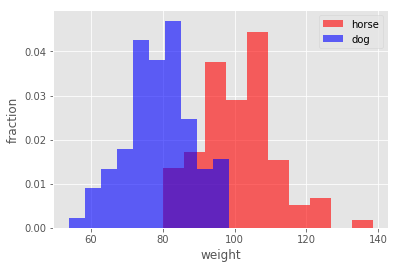

In [6]:
plt.hist(x_weights[y==1], 
         label='horse', 
         color='red',
         density=True,
         alpha=0.6)
plt.hist(x_weights[y==0], 
         label='dog', 
         color='blue', 
         density=True,
         alpha=0.6)
plt.legend()
plt.xlabel('weight')
plt.ylabel('fraction');

In [11]:
x_weights.shape

(200, 1)

In [12]:
y.shape

(200,)

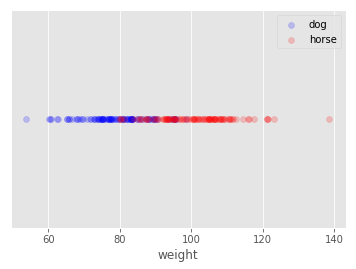

In [19]:
plt.scatter(x_weights[y==0], np.zeros(x_weights[y==0].shape), 
            c='b', label='dog', alpha=0.2)
plt.scatter(x_weights[y==1], np.zeros(x_weights[y==1].shape), 
            c='r', label='horse', alpha=0.2)
plt.xlabel('weight')
plt.yticks([])
plt.legend();

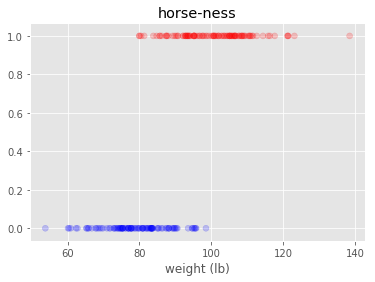

In [7]:
plt.scatter(x_weights, y, c=y, cmap='bwr', alpha=0.2)
plt.xlabel('weight (lb)')
plt.title('horse-ness');

well fitting a line to this seems dumb.

let's do it

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
linear_model = LinearRegression()
linear_model.fit(x_weights, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [10]:
x_ = np.linspace(x_weights.min(), x_weights.max())
slope = linear_model.coef_
intercept = linear_model.intercept_

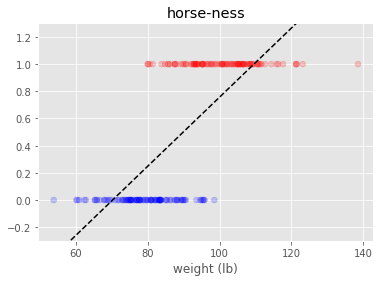

In [11]:
plt.scatter(x_weights, y, c=y, cmap='bwr', alpha=0.2)
plt.xlabel('weight (lb)')
plt.title('horse-ness')
plt.plot(x_, slope*x_ + intercept, 'k--')
plt.ylim([-0.3,1.3]);

In [12]:
linear_model.predict(np.array(140).reshape(1,1))

array([1.77401462])

In [13]:
linear_model.predict(np.array(30).reshape(1,1))

array([-1.02146929])

yeah pretty dumb

# Logistic Regression: Derivation

### Remember linear regression?

There we assumed the data follows the form

$$\begin{align}
Y & = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... \beta_p X_p + \epsilon \\
  & = \mathbf{X} \vec{\beta} + \epsilon
\end{align}$$

where 

$$\epsilon \sim N(0, \sigma)$$

Equivalently, we could write
$$Y \sim N(\mathbf{X} \vec{\beta}, \sigma)$$

From there, we want to find the values for $\vec{\beta}$ under which the data is most likely. We can frame this as a maximum likelihood problem:

$$ L(\vec{\beta}) = f(Y | \vec{\beta}, \mathbf{X}) = \prod_i f(y_i | \vec{\beta}, \vec{x}_i) $$

where $f(y_i | \vec{\beta}, \vec{x}_i)$ here is the probability density function for the normal distribution with mean $\vec{x}_i \cdot \vec{\beta}$ and variance $\sigma^2$ evaluated at $y_i$

The values of $\vec{\beta}$ that maximize the likelihood $L$ above turn out to be the same values that minimize sum of squared errors, 
$$SSE = \sum_i (y_i - \vec{x}_i\cdot\vec{\beta})^2$$

See the proof of this [here](https://www.statlect.com/fundamentals-of-statistics/linear-regression-maximum-likelihood#hid5)

To recap:

Above, we assumed $y \sim N(\mu, \sigma)$, and we assumed $\mu$ was a function of $\vec{x}$. Not just any function, but a linear combination of  $\vec{x}$'s components.
$$ \mu = h(\vec{x}) =  \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots $$

So...

### How can we do the same when $y$ is categorical instead of numerical?

Let's stick with binary classification: $y \in \{0, 1\}$

#### Two values? Sounds Bernoulli enough for me

Let's assume every $y$ is a Bernoulli trial whose probability $p$ depends on $\vec{x}$

$$ y \sim \text{Bernoulli}(p) = \text{Bernoulli}(h(\vec{x}))$$ 

Let's make another assumption: this function $h(\vec{x})$ is a function of a linear combination of $\vec{x}$'s components:
$$ p = h(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots) = h(\vec{\beta}\cdot\vec{x})$$

Now we gotta come up with a function. I'll pull this out of a textbook and see how it behaves.

$$ h(\theta) = \frac{1}{1 + e^{-\theta}} $$

So
$$ p(\vec{x}) = h(\vec{\beta}\cdot\vec{x}) = \frac{1}{1 + e^{-(\vec{\beta}\cdot\vec{x})}} =  \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots)}}  $$


These are the modeling assumptions for logistic regression. 

### Finding the $\beta$ coefficients

Now we can construct a likelihood function

We assume 
$$y \sim Bernoulli(h(\vec{x}\cdot \vec{\beta}))$$

For a Bernoulli trial with success probability $p$, the likelihood is
$$ P(y|p) = p^y(1-p)^{1-y} $$

So for our case, 

$$L(\vec{\beta}) = \prod_i h(\vec{\beta}\cdot \vec{x}_i)^{y_i}(1-h(\vec{\beta}\cdot \vec{x}_i))^{1-y_i}$$

Unfortunately, setting the derivative of the likelihood to zero results in a set of nonlinear equations for $\beta_j$ that has **no analytical solution**. Frowning emoticon.

This afternoon we'll show how to numerically maximize the likelihood. For computational convenience, we often use the log likelihood. 

$$\log L(\vec{\beta}) = \sum_i \left(\, y_i\,\text{log}(h(\vec{\beta}\cdot \vec{x}_i)) + (1 - y_i)\log(1 - h(\vec{\beta}\cdot \vec{x}_i))\, \right)$$

Also, since in general we talk about minimizing a cost function, let's call the cost function $J$ for logistic regression the *negative log likelihood*
$$ J(\vec{\beta}) = -\log L(\vec{\beta}) $$

For now, take it for granted that we can call `.fit()` and get out the values of the $\beta$ parameters that maximize the likelihood (and so minimize $J$)

#### Logistic regression with one variable (weight)

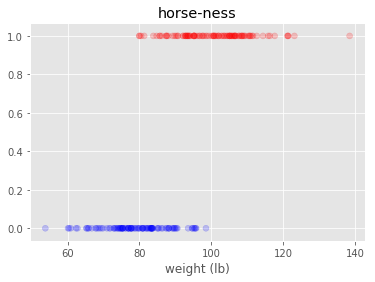

In [14]:
plt.scatter(x_weights, y, c=y, cmap='bwr', alpha=0.2)
plt.xlabel('weight (lb)')
plt.title('horse-ness');

Model the probability with the following formula:

$$ P(\text{horse}\,|\,x) = p(x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x)}}$$

##### statsmodels syntax

In [15]:
import statsmodels.api as sm
logsm = sm.Logit(y, sm.add_constant(x_weights))
logsm_results = logsm.fit()
logsm_results.summary()

Optimization terminated successfully.
         Current function value: 0.292122
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:                          Logit   Df Residuals:                      198
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 Feb 2019   Pseudo R-squ.:                  0.5786
Time:                        11:01:48   Log-Likelihood:                -58.424
converged:                       True   LL-Null:                       -138.63
                                        LLR p-value:                 9.206e-37
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -22.0656      3.110     -7.094      0.000     -28.162     -15.969
x1             0.2470      0.035      7.089      0.000       0.179       0.315
==============================================================================
"""

In [16]:
xx = np.linspace(50,140).reshape(-1,1)
pred_prob = logsm_results.predict(sm.add_constant(xx))
pred_prob[:10]

array([6.03706778e-05, 9.50276149e-05, 1.49577051e-04, 2.35432547e-04,
       3.70549842e-04, 5.83167187e-04, 9.17669986e-04, 1.44376532e-03,
       2.27078282e-03, 3.56983878e-03])

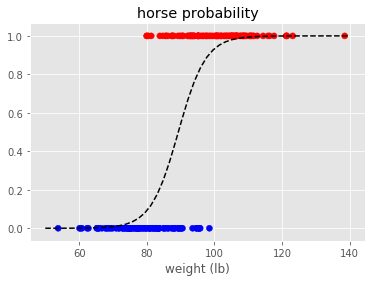

In [17]:
plt.scatter(x_weights, y, c=y, cmap='bwr')
plt.plot(xx, pred_prob, "k--")
plt.xlabel('weight (lb)')
plt.title('horse probability');

##### sklearn syntax

In [18]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()
log_model.fit(x_weights, y)

/home/moses/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
log_model.coef_

array([[0.06424881]])

In [20]:
log_model.intercept_

array([-5.6306737])

Note that `sklearn`'s `predict_proba()` method returns the predicted probabilities for each class ($0$ and $1$).

In [21]:
xx = np.linspace(50,140).reshape(-1,1)
pred_prob_sk = log_model.predict_proba(xx)
pred_prob_sk[:10]

array([[0.91820717, 0.08179283],
       [0.90889571, 0.09110429],
       [0.89864123, 0.10135877],
       [0.88737555, 0.11262445],
       [0.87503185, 0.12496815],
       [0.86154637, 0.13845363],
       [0.84686033, 0.15313967],
       [0.83092222, 0.16907778],
       [0.81369028, 0.18630972],
       [0.79513511, 0.20486489]])

In [22]:
pred_prob_sk_horse = pred_prob_sk[:,1]

In [23]:
pred_prob_sk_horse[:10]

array([0.08179283, 0.09110429, 0.10135877, 0.11262445, 0.12496815,
       0.13845363, 0.15313967, 0.16907778, 0.18630972, 0.20486489])

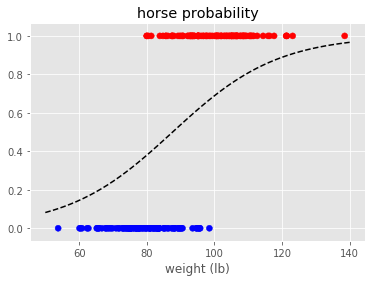

In [24]:
plt.scatter(x_weights, y, c=y, cmap='bwr')
plt.plot(xx, pred_prob_sk_horse, "k--")
plt.xlabel('weight (lb)')
plt.title('horse probability');

Why is this curve so different? It turns out that the `sklearn` implementation of logistic regression is **regularized by default**. That is, its cost function is
$$J(\vec{\beta}) = (-\log L(\vec{\beta})) + \lambda |\vec{\beta}|^2 $$

`sklearn`'s `LogisticRegression` controls regularization with the parameter `C`, where `C = 1/lambda`. The default value of `C` is 1. To relax the regularization constraint, make `C` higher.

In [25]:
log_model_unreg = LogisticRegression(C=1000)
log_model_unreg.fit(x_weights, y)

/home/moses/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [26]:
log_model_unreg.intercept_, log_model_unreg.coef_

(array([-21.76263018]), array([[0.24362914]]))

In [27]:
xx = np.linspace(50,140).reshape(-1,1)
pred_prob_sk_unreg = log_model_unreg.predict_proba(xx)[:,1]

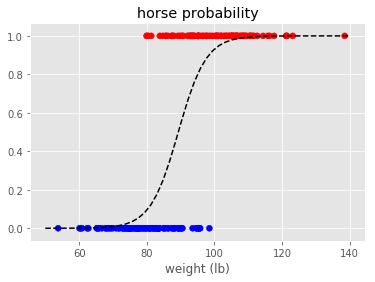

In [28]:
plt.scatter(x_weights, y, c=y, cmap='bwr')
plt.plot(xx, pred_prob_sk_unreg, "k--")
plt.xlabel('weight (lb)')
plt.title('horse probability');

### How do you score a soft classifier?

**[log loss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)** is simply the negative log likelihood defined above

In [29]:
from sklearn.metrics import log_loss

To get the total log loss, specify `normalize=False`, otherwise you will get the average log loss per sample.

In [30]:
train_pred_probs = log_model_unreg.predict_proba(x_weights)

In [31]:
log_loss(y, train_pred_probs, normalize=False)

58.429254087786745

In [32]:
log_loss(y, train_pred_probs)

0.2921462704389337

Sanity check: the results from the statsmodels implementation should be the same

In [33]:
log_loss(y, logsm_results.predict(sm.add_constant(x_weights)))

0.29212228030806175

Log loss also generalizes to multiple classes, see the [sklearn user guide](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss)

### Logistic regression with two features

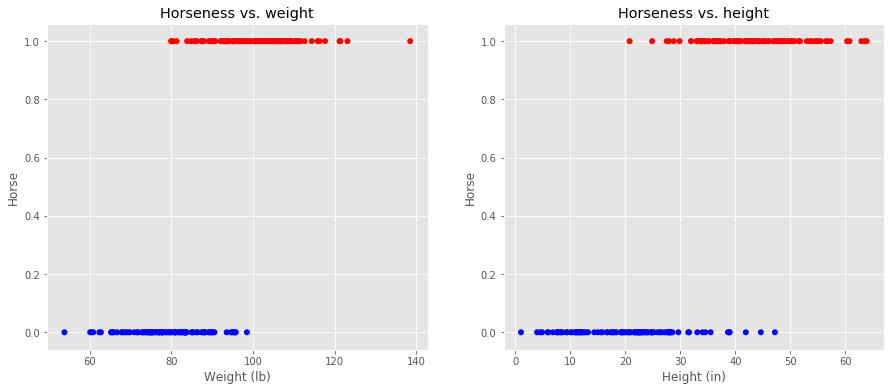

In [34]:
fig, axes = plt.subplots(1,2, figsize=(15,6))

axes[0].scatter(X[:,0], y, c=y, cmap='bwr', edgecolor='')
axes[0].set_xlabel('Weight (lb)')
axes[0].set_ylabel('Horse')
axes[0].set_title('Horseness vs. weight')
axes[1].scatter(X[:,1], y, c=y, cmap='bwr', edgecolor='')
axes[1].set_xlabel('Height (in)')
axes[1].set_ylabel('Horse')
axes[1].set_title('Horseness vs. height');

In [35]:
X_dogs = X[y == 0]
X_horses = X[y == 1]
y_dogs = y[ y== 0]
y_horses = y[ y== 1]

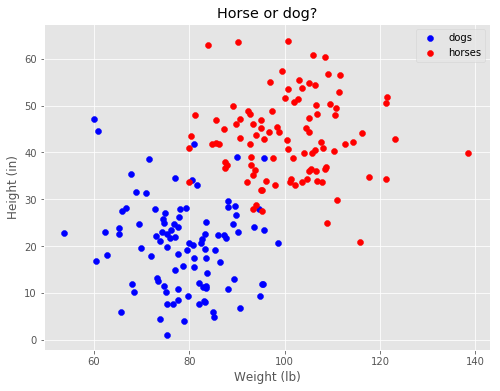

In [36]:
plt.figure(figsize=(8,6))
plt.scatter(X_dogs[:,0], X_dogs[:,1], color='b', label='dogs')
plt.scatter(X_horses[:,0], X_horses[:,1], color='r', label='horses')
plt.legend()
plt.xlabel('Weight (lb)')
plt.ylabel('Height (in)')
plt.title('Horse or dog?')
plt.show()

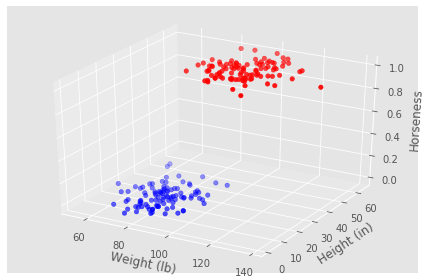

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], y, c=y, cmap='bwr')
ax.set_xlabel('Weight (lb)')
ax.set_ylabel('Height (in)')
ax.set_zlabel('Horseness')
plt.tight_layout()
plt.show()

### what does this function $p(\text{weight}, \text{height})$ look like?

In [38]:
log_model = LogisticRegression(C=1000)
log_model.fit(X,y)

/home/moses/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [39]:
x_ = np.linspace(40, 160, 100)
log_model.coef_[0]
discriminator_line = -(log_model.intercept_ + log_model.coef_[0][0]*x_)/log_model.coef_[0][1]

In [50]:
# to get interactive plot widgets, follow the installation
# instructions here: https://github.com/matplotlib/jupyter-matplotlib

%matplotlib widget

In [43]:
xx, yy = np.meshgrid(np.linspace(40,160,300), np.linspace(0,70,300))
xy = np.c_[xx.ravel(), yy.ravel()]
z = log_model.predict_proba(xy)[:,1].reshape(xx.shape)

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:,0], X[:,1], y, c=y, cmap='bwr')
ax.set_xlim([50,145])
ax.set_ylim([0,65])
ax.set_xlabel('Weight (lb)')
ax.set_ylabel('Height (in)')
ax.set_zlabel('Horse Probability')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X[:,0], X[:,1], y, c=y, cmap='bwr')
ax2.plot_surface(xx, yy, z, cmap='bwr', alpha=0.3, rstride=7, cstride=7)
ax2.plot(x_, discriminator_line, zs=0.5, linestyle='--', color='g')
ax2.set_xlim([50,145])
ax2.set_ylim([0,65])
ax2.set_xlabel('Weight (lb)')
ax2.set_ylabel('Height (in)')
ax2.set_zlabel('Horse Probability')
plt.tight_layout()

FigureCanvasNbAgg()

In [52]:
%matplotlib inline

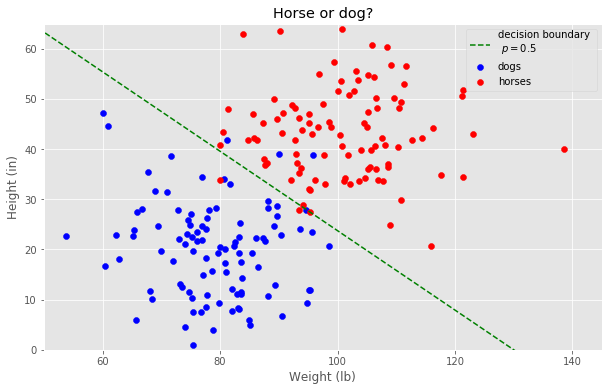

In [47]:
plt.figure(figsize=(10,6))
plt.scatter(X_dogs[:,0], X_dogs[:,1], color='b', label='dogs')
plt.scatter(X_horses[:,0], X_horses[:,1], color='r', label='horses')
plt.plot(x_, discriminator_line, 'g--', label = "decision boundary \n $p=0.5$")
plt.xlim([50,145])
plt.ylim([0,65])
plt.legend()
plt.xlabel('Weight (lb)')
plt.ylabel('Height (in)')
plt.title('Horse or dog?')
plt.show()

#### exercise: how can you derive the decision boundary for p=0.5? How about some other probability p=t?

### What do these $\beta$ parameters mean???

For the moment let $\theta = \vec{\beta}\cdot\vec{x} $

Then $$p = h(\theta) = \frac{1}{1 + e^{-\theta}} $$

If we invert this formula, we get
$$ \theta = \text{ln}\left(\frac{p}{1-p}\right)$$

Let's break this down.

What does probability $p$ represent in a Bernoulli trial?

$p \sim \frac{\#successes}{\#trials}$

$p \in [0,1]$

$\frac{p}{1-p}$ has a name: it's the odds. I'll use $d$ to represent odds

$d = \frac{p}{1-p}$ ; $p = \frac{d}{1+d}$

$d \sim \frac{\#successes}{\#failures}$

$d \in [0, \infty)$

So now,
$\theta  = \ln(\frac{p}{1-p}) = \ln(d)$

$\theta \in (-\infty, \infty)$

$\theta$ is the **log of the odds**

So the assumption we're making in logistic regression is that ***the log odds are modeled by a linear combination of our features***.

That's our map from feature space to class probabilities.

## Interpreting the coefficients

#### Let's work in just one dimension, and consider only a one-unit change in $x$

$\theta(x) =\beta_0 + \beta_1x$

$\theta(0) = \beta_0$

$\theta(1) = \beta_0 + \beta_1$

$d(x) = e^{\theta(x)}$

$d(0) = e^{\theta(0)} = e^{\beta_0}$

$d(1) = e^{\theta(1)} = e^{\beta_0 + \beta_1}$ = $e^{\beta_0}e^{\beta_1} = d(0)e^{\beta_1}$

$\frac{d(1)}{d(0)} = e^{\beta_1}$

Thus, a one-unit increase in $x$ corresponds to a $\beta_1$ increase in the log-odds, which is an $e^{\beta_1}$ **multiplicative factor** on the odds. This ratio between two odds is called an *odds ratio*.

#### This is as interpretable as it gets, which is OK! Odds are very intuitive! "the number of successes over the number of failures"

$\beta_1 \rightarrow \infty \Rightarrow p_1 \rightarrow 1$

$\beta_1 = 0 \Rightarrow p_1 = p_0$

$\beta_1 \rightarrow -\infty \Rightarrow p_1 \rightarrow 0$

In [48]:
import pandas as pd

In [49]:
x = np.arange(-10, 11)
df = pd.DataFrame(['{:.3f}%'.format(a*100) for a in 1/(1+np.exp(-x))], index=x, columns=['probability'])
df.index.name = 'log odds'
df

,probability
log odds,
-10,0.005%
-9,0.012%
-8,0.034%
-7,0.091%
-6,0.247%
-5,0.669%
-4,1.799%
-3,4.743%
-2,11.920%
